# 🐦🗺️ CAMAR Project
**Proyek Penelitian S3 PSL-IPB**: Model Simulasi Prediksi Perubahan LULC (Land Use/Land Cover)

**Peneliti**: Seniarwan<sup>1</sup>, dibawah bimbingan [Prof. Baba Barus](https://scholar.google.co.id/citations?hl=id&user=zOtjie8AAAAJ)<sup>2</sup>, [Prof. Suria D. Tarigan](https://scholar.google.com/citations?user=ukdzSPsAAAAJ&hl=id&oi=ao)<sup>2</sup>, dan [Prof. Agus Buono](https://scholar.google.com/citations?user=CDIv9k0AAAAJ&hl=en)<sup>3</sup>  
<br>
   <sup>1</sup> *Mahasiswa S3, Sekolah Pascasarjana, Program Studi Ilmu Pengelolaan Sumberdaya ALam dan Lingkungan, IPB University (psl24seniarwan@apps.ipb.ac.id).*
   
   <sup>2</sup> *Departemen Ilmu Tanah dan Sumberdaya Lahan, Fakultas Pertanian, IPB University, Indonesia*
   
   <sup>3</sup> *Departemen Ilmu Komputer, Sekolah Sains Data, Matematika, dan Informatika (SSMI), IPB University, Indonesia*  
<br>

**CAMAR** adalah sebuah kerangka kerja pemodelan spasial yang dikembangkan dengan Python untuk simulasi dan prediksi perubahan LULC di masa depan. Nama model ini dipilih sebagai akronim dari `Cellular Automata-Markov for Land Change Simulator`, sekaligus sebagai metafora atas kemampuan burung Camar dalam membaca perubahan lingkungan dan beradaptasi secara spasial.  
<br>

Proyek ini dirancang untuk menjadi model fleksibel, tangguh, dan mudah diadaptasi untuk berbagai skenario penelitian, terutama dalam konteks perencanaan tata ruang, analisis dampak bencana/lingkungan, dan studi urbanisasi. Pada notebook telah tersedia data sampel yang diakses langsung melalui gdrive dan model yang dapat langsung dijalankan.  




     
     
     
  <br>
  <br>
   $$\text{=== WORK IN PROGRESS ===}$$

In [1]:
# @title Install Library

!pip install rasterio --quiet
!pip install --no-deps camar_core-0.2.0-cp311-cp311-linux_x86_64.whl --force-reinstall


Total files found in folder: 1
Downloading: camar_core-0.2.0-cp311-cp311-linux_x86_64.whl -> /content/camar_core-0.2.0-cp311-cp311-linux_x86_64.whl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.9 MB/s eta 0:00:00
Processing ./camar_core-0.2.0-cp311-cp311-linux_x86_64.whl


In [3]:
# @title Load Data Input from Gdrive
import os

# GDrive Authentication
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate ke Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Buat direktori lokal jika belum ada
local_download_path = '/content/input_data/'
os.makedirs(local_download_path, exist_ok=True)

# Ganti ID folder dengan milik Anda!
gdrive_folder_id = '1l7BP36Jqjqe3_MobZX7R2DdZniNcXoUc'

file_list = drive.ListFile({'q': f"'{gdrive_folder_id}' in parents and trashed=false"}).GetList()
print(f"Total files found in folder: {len(file_list)}")

for f in file_list:
    fname = os.path.join(local_download_path, f['title'])
    print(f"Downloading: {f['title']} (ID: {f['id']}) -> {fname}")
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

print("All files downloaded!")

# Links to input rasters for pipeline use
t0     = os.path.join(local_download_path, 'pl2015.tif')
t1     = os.path.join(local_download_path, 'pl2020.tif')
t2    = os.path.join(local_download_path, 'pl2024.tif')
suitmap  = os.path.join(local_download_path, 'suitmap.tif')

Total files found in folder: 4
Downloading: pl2020.tif (ID: 1m_qWd1bj_Os4lxxDiYrKfY4zrfxaXW_r) -> /content/input_data/pl2020.tif
Downloading: pl2015.tif (ID: 1SJNOGIOHSDbD3BJ7MDa_DQ4RSl9RdPTn) -> /content/input_data/pl2015.tif
Downloading: suitmap.tif (ID: 1ATo87PfiKDwNW4YrJec1Dh1-6hIJ-XsU) -> /content/input_data/suitmap.tif
Downloading: pl2024.tif (ID: 16Z07o4F_yLby6fGrN6DptQzi6QrEcfMX) -> /content/input_data/pl2024.tif
All files downloaded!


In [4]:
# @title Persiapan dan Konfigurasi
# ==============================================================================
# LANGKAH 1: PERSIAPAN ENVIRONMENT
# ==============================================================================
try:
    import importlib
    import camar as cam
    importlib.reload(cam)

    import os
    import sys
    import rasterio
    import numpy as np
    import pandas as pd
    import logging

    print("✅ Semua pustaka berhasil diimpor.")

except ImportError as e:
    print("❌ ERROR: Gagal mengimpor pustaka. Detail:", e)

except Exception as e:
    print(f"❌ Terjadi error lain: {e}")



# ==============================================================================
# LANGKAH 2: KONFIGURASI SIMULASI
# ==============================================================================

# --- Konfigurasi Direktori ---
DATA_DIR_INPUT = "input_data" # Pastikan folder ini ada dan berisi data Anda
DATA_DIR_OUTPUT = "output_data" # Membuat folder untuk menyimpan semua hasil

# --- Konfigurasi Peta Historis ---
HISTORICAL_TIME_STEPS = [2015, 2020, 2024]
HISTORICAL_MAPS = ["pl2015.tif", "pl2020.tif", "pl2024.tif"]

# --- Konfigurasi Validasi ---
# Definisikan tahun mana dari data historis yang akan digunakan untuk validasi
VALIDATION_YEARS = [2024]

# --- Konfigurasi Peta Input Lainnya ---
SUITABILITY_MAP = "suitmap.tif"
CONSTRAINT_MAP_FILE = "constraints.tif"
URBAN_CLASS_CODE = 8

# --- Pilih metode proyeksi transisi ---
TREND_METHOD = "linear"      # Pilihan: "linear", "logarithmic", atau "quadratic"

# Konfigurasi label kelas yang sesuai
LULC_CLASS = {
    1: 'Hutan',
    2: 'Rawa',
    3: 'Mangrove',
    4: 'Semak Belukar',
    5: 'Perkebunan',
    6: 'Pertanian Lahan Kering',
    7: 'Sawah',
    8: 'Lahan Terbangun',
    9: 'Tambak',
    10: 'Tubuh Air',
    11: 'Lainnya',
}




Package 'camar' v0.2.0 berhasil diinisialisasi.
INFO: Optimasi Cython AKTIF.
✅ Semua pustaka berhasil diimpor.


In [5]:
# @title Jalankan Model
# ==============================================================================
# LANGKAH 3: EKSEKUSI ALUR KERJA SIMULASI
# ==============================================================================

logging.basicConfig(filename=os.path.join(DATA_DIR_OUTPUT, 'simulation.log'),
                    level=logging.WARNING,
                    format='%(asctime)s - %(levelname)s - %(message)s')
print(f"Logging diaktifkan ke file {os.path.join(DATA_DIR_OUTPUT, 'simulation.log')}")

# --- Memuat Data Awal ---
os.makedirs(DATA_DIR_INPUT, exist_ok=True)
os.makedirs(DATA_DIR_OUTPUT, exist_ok=True)
print("Memuat data historis...")

maps_data, nodata_val = {}, None
try:
    for year, map_file in zip(HISTORICAL_TIME_STEPS, HISTORICAL_MAPS):
        with rasterio.open(os.path.join(DATA_DIR_INPUT, map_file)) as src:
            maps_data[year] = src.read(1)
            if nodata_val is None:
                nodata_val = src.nodata if src.nodata is not None else -9999.0
except rasterio.errors.RasterioIOError as e:
    print(f"Error: Tidak dapat membuka file raster: {e}"); sys.exit(1)

num_classes_auto = int(max(np.max(m[m != nodata_val]) for m in maps_data.values()))
print(f"Jumlah kelas terdeteksi: {num_classes_auto}")

# Memanggil fungsi dari modul inti untuk menentukan tahun prediksi
TARGET_YEARS = cam.generate_target_years(HISTORICAL_TIME_STEPS)
print(f"Tahun target yang diperbolehkan: {TARGET_YEARS}")

# --- TAHAP 1: VALIDASI MODEL ---
print("\n" + "="*50 + "\nTAHAP 1: VALIDASI MODEL\n" + "="*50)
for validation_year in VALIDATION_YEARS:
    try:
        val_index = HISTORICAL_TIME_STEPS.index(validation_year)
        if val_index < 1:
            print(f"Warning: Tidak cukup data historis untuk memvalidasi tahun {validation_year}. Melewati.")
            continue

        start_year = HISTORICAL_TIME_STEPS[val_index - 1]
        trend_start_year = HISTORICAL_TIME_STEPS[val_index - 2] if val_index > 1 else start_year

        print(f"\n--- Memvalidasi prediksi untuk {validation_year} dari {start_year} ---")
        print(f"Menggunakan tren dari periode {trend_start_year}-{start_year}")

        validation_tm, _ = cam.calculate_transition_matrix(maps_data[trend_start_year], maps_data[start_year], num_classes_auto, nodata_val)
        validation_tm = cam.lock_urban_class(validation_tm, URBAN_CLASS_CODE)

        common_args_val = {
            'output_dir': DATA_DIR_OUTPUT,
            'suitmap_file': os.path.join(DATA_DIR_INPUT, SUITABILITY_MAP),
            'num_classes': num_classes_auto,
            'kernel': cam.CONTIGUITY_KERNEL, 'contiguity_offset': cam.CONTIGUITY_OFFSET,
            'majority_filter_size': cam.MAJORITY_FILTER_SIZE, 'nodata_val': nodata_val,
            'urban_class_code': URBAN_CLASS_CODE, 'tile_size': cam.TILE_SIZE
        }

        validation_args = {
            **common_args_val,
            'start_map_file': os.path.join(DATA_DIR_INPUT, HISTORICAL_MAPS[val_index - 1]),
            'target_year': validation_year,
            'transition_matrix': validation_tm,
            'num_steps': validation_year - start_year
        }

        constraint_path = os.path.join(DATA_DIR_INPUT, CONSTRAINT_MAP_FILE)
        sim_mode = 'demand_driven' if (CONSTRAINT_MAP_FILE and os.path.exists(constraint_path)) else 'evolutionary'
        if sim_mode == 'demand_driven':
            validation_args.update({'constraint_file': os.path.join(DATA_DIR_INPUT, CONSTRAINT_MAP_FILE)})

        predicted_map_for_validation = cam.run_simulation_wrapper(sim_mode, **validation_args)

        if predicted_map_for_validation and os.path.exists(predicted_map_for_validation):
            cam.validate_prediction(predicted_map_for_validation, os.path.join(DATA_DIR_INPUT, HISTORICAL_MAPS[val_index]), nodata_val, LULC_CLASS)
    except (ValueError, IndexError) as e:
        print(f"Error saat menyiapkan validasi untuk tahun {validation_year}: {e}")

# --- TAHAP 2: PREDIKSI LULC MASA DEPAN ---
print("\n" + "="*50 + "\nTAHAP 2: PREDIKSI LULC MASA DEPAN\n" + "="*50)

# Siapkan data input untuk proyeksi
t_minus_2, t_minus_1, t_last = HISTORICAL_TIME_STEPS[-3], HISTORICAL_TIME_STEPS[-2], HISTORICAL_TIME_STEPS[-1]
matrix_A, _ = cam.calculate_transition_matrix(maps_data[t_minus_2], maps_data[t_minus_1], num_classes_auto, nodata_val)
matrix_B, _ = cam.calculate_transition_matrix(maps_data[t_minus_1], maps_data[t_last], num_classes_auto, nodata_val)

# Jika menggunakan quadratic, siapkan semua transition matrix dan years:
if TREND_METHOD == "quadratic":
    transition_matrices = []
    years = []
    for k in range(len(HISTORICAL_TIME_STEPS) - 1):
        tm, _ = cam.calculate_transition_matrix(
            maps_data[HISTORICAL_TIME_STEPS[k]],
            maps_data[HISTORICAL_TIME_STEPS[k+1]],
            num_classes_auto, nodata_val
        )
        transition_matrices.append(tm)
        years.append(HISTORICAL_TIME_STEPS[k+1])

current_start_map_path = os.path.join(DATA_DIR_INPUT, HISTORICAL_MAPS[-1])
current_start_year = HISTORICAL_TIME_STEPS[-1]

common_args_pred = {
    'output_dir': DATA_DIR_OUTPUT,
    'suitmap_file': os.path.join(DATA_DIR_INPUT, SUITABILITY_MAP),
    'num_classes': num_classes_auto,
    'kernel': cam.CONTIGUITY_KERNEL, 'contiguity_offset': cam.CONTIGUITY_OFFSET,
    'majority_filter_size': cam.MAJORITY_FILTER_SIZE, 'nodata_val': nodata_val,
    'urban_class_code': URBAN_CLASS_CODE, 'tile_size': cam.TILE_SIZE
}

for target_year in TARGET_YEARS:
    print(f"\n--- Memulai prediksi untuk tahun {target_year} dari {current_start_year} ---")

    # --- PILIH PROYEKSI SESUAI TREND_METHOD ---
    if TREND_METHOD == "quadratic":
        # Proyeksi quadratic regression, gunakan wrapper quadratic_regression
        projected_dict = cam.quadratic_regression(transition_matrices, years, TARGET_YEARS)
        projected_matrix = projected_dict[target_year]
    elif TREND_METHOD == "logarithmic":
        projected_matrix = cam._interpolate_logarithmic(
            matrix_A, matrix_B, [t_minus_1, t_last], target_year, t_last
        )
    else:  # default linear
        projected_matrix = cam._interpolate_linear(
            matrix_A, matrix_B, [t_minus_1, t_last], target_year, t_last
        )
    projected_matrix = cam.lock_urban_class(projected_matrix, URBAN_CLASS_CODE)

    # Simpan matriks proyeksi (opsional)
    df_proj_viz = pd.DataFrame(projected_matrix,
                               columns=[LULC_CLASS.get(i+1) for i in range(num_classes_auto)],
                               index=[LULC_CLASS.get(i+1) for i in range(num_classes_auto)])
    output_matrix_path = os.path.join(DATA_DIR_OUTPUT, f"projected_matrix_{target_year}.csv")
    df_proj_viz.to_csv(output_matrix_path)
    print(f"Matriks Transisi Proyeksi untuk {target_year} disimpan di {output_matrix_path}")

    prediction_args = {
        **common_args_pred,
        'start_map_file': current_start_map_path,
        'target_year': target_year,
        'transition_matrix': projected_matrix,
        'num_steps': target_year - current_start_year
    }

    if sim_mode == 'demand_driven':
        prediction_args.update({'constraint_file': os.path.join(DATA_DIR_INPUT, CONSTRAINT_MAP_FILE)})

    predicted_map_path = cam.run_simulation_wrapper(sim_mode, **prediction_args)

    if predicted_map_path and os.path.exists(predicted_map_path):
        current_start_map_path = predicted_map_path
        current_start_year = target_year
    else:
        print(f"Gagal membuat prediksi untuk {target_year}. Menghentikan simulasi berantai.")
        break

print("\nProses Selesai.")



Logging diaktifkan ke file output_data/simulation.log
Memuat data historis...
Jumlah kelas terdeteksi: 11
Tahun target yang diperbolehkan: [2030, 2035]

TAHAP 1: VALIDASI MODEL

--- Memvalidasi prediksi untuk 2024 dari 2020 ---
Menggunakan tren dari periode 2015-2020

--- Menjalankan Simulasi untuk Target: 2024 ---


Merging Tiles for 2024: 100%|██████████| 3234/3234 [00:10<00:00, 311.23it/s]


Simulasi mode evolusi selesai. Hasil disimpan di: output_data/predicted_map_evolutionary_2024.tif

--- Menghitung Akurasi Model ---
Cohen's Kappa: 0.7922
Overall Jaccard Score: 0.7241
Overall Precision: 0.8436
Overall Recall: 0.8363
Overall F1-Score: 0.8362

Metrik per Kelas:
╒════════════════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Kelas                  │   Precision │   Recall │   F1-Score │   Support │
╞════════════════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Hutan                  │    0.958657 │ 0.975894 │   0.967199 │    814607 │
├────────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Rawa                   │    0.621891 │ 0.838926 │   0.714286 │       745 │
├────────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Mangrove               │    0.87185  │ 0.681337 │   0.764909 │     46761 │
├────────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Semak Belukar          │    

Merging Tiles for 2030: 100%|██████████| 3234/3234 [00:10<00:00, 298.76it/s]

Simulasi mode evolusi selesai. Hasil disimpan di: output_data/predicted_map_evolutionary_2030.tif

--- Memulai prediksi untuk tahun 2035 dari 2030 ---
Matriks Transisi Proyeksi untuk 2035 disimpan di output_data/projected_matrix_2035.csv

--- Menjalankan Simulasi untuk Target: 2035 ---



Merging Tiles for 2035: 100%|██████████| 3234/3234 [00:11<00:00, 293.25it/s]

Simulasi mode evolusi selesai. Hasil disimpan di: output_data/predicted_map_evolutionary_2035.tif

Proses Selesai.



Tabel Detail Perubahan Luas (Hektar)
                             2015       2020       2024       2030       2035
Hutan                     831,335    819,586    814,787    831,803    837,015
Lahan Terbangun         2,626,154  3,020,443  3,376,365  3,895,303  4,185,365
Lainnya                    71,016     70,142     69,870     46,511     42,367
Mangrove                   34,100     33,510     46,850     36,451     36,128
Perkebunan              2,222,638  2,192,813  2,201,983  2,201,436  2,194,131
Pertanian Lahan Kering  3,502,084  3,315,538  2,734,128  2,733,396  2,597,640
Rawa                        1,359      1,003        745        718        789
Sawah                   3,796,280  3,649,635  3,869,760  3,394,096  3,253,606
Semak Belukar             124,961    111,925    110,972    103,392    103,436
Tambak                    217,336    212,668    199,170    208,043    205,766
Tubuh Air                  91,239     91,239     93,872     67,614     62,763
Data perubahan luas dieksp

<Figure size 1200x600 with 0 Axes>

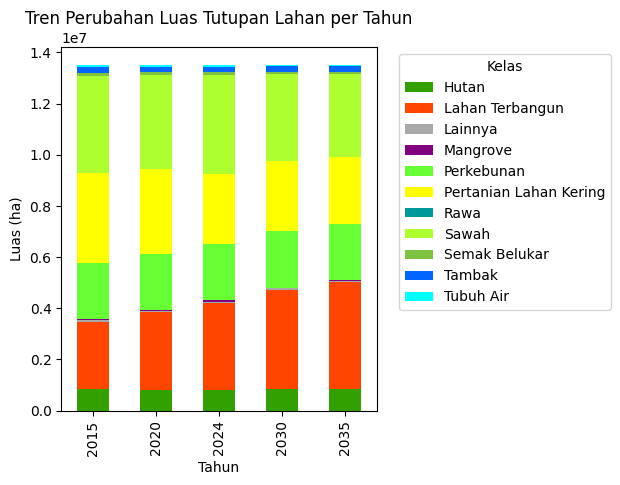


--- Menghasilkan Visualisasi Urutan Peta ---
Visualisasi urutan peta disimpan sebagai: output_data/visualisasi_sekuens_peta.png


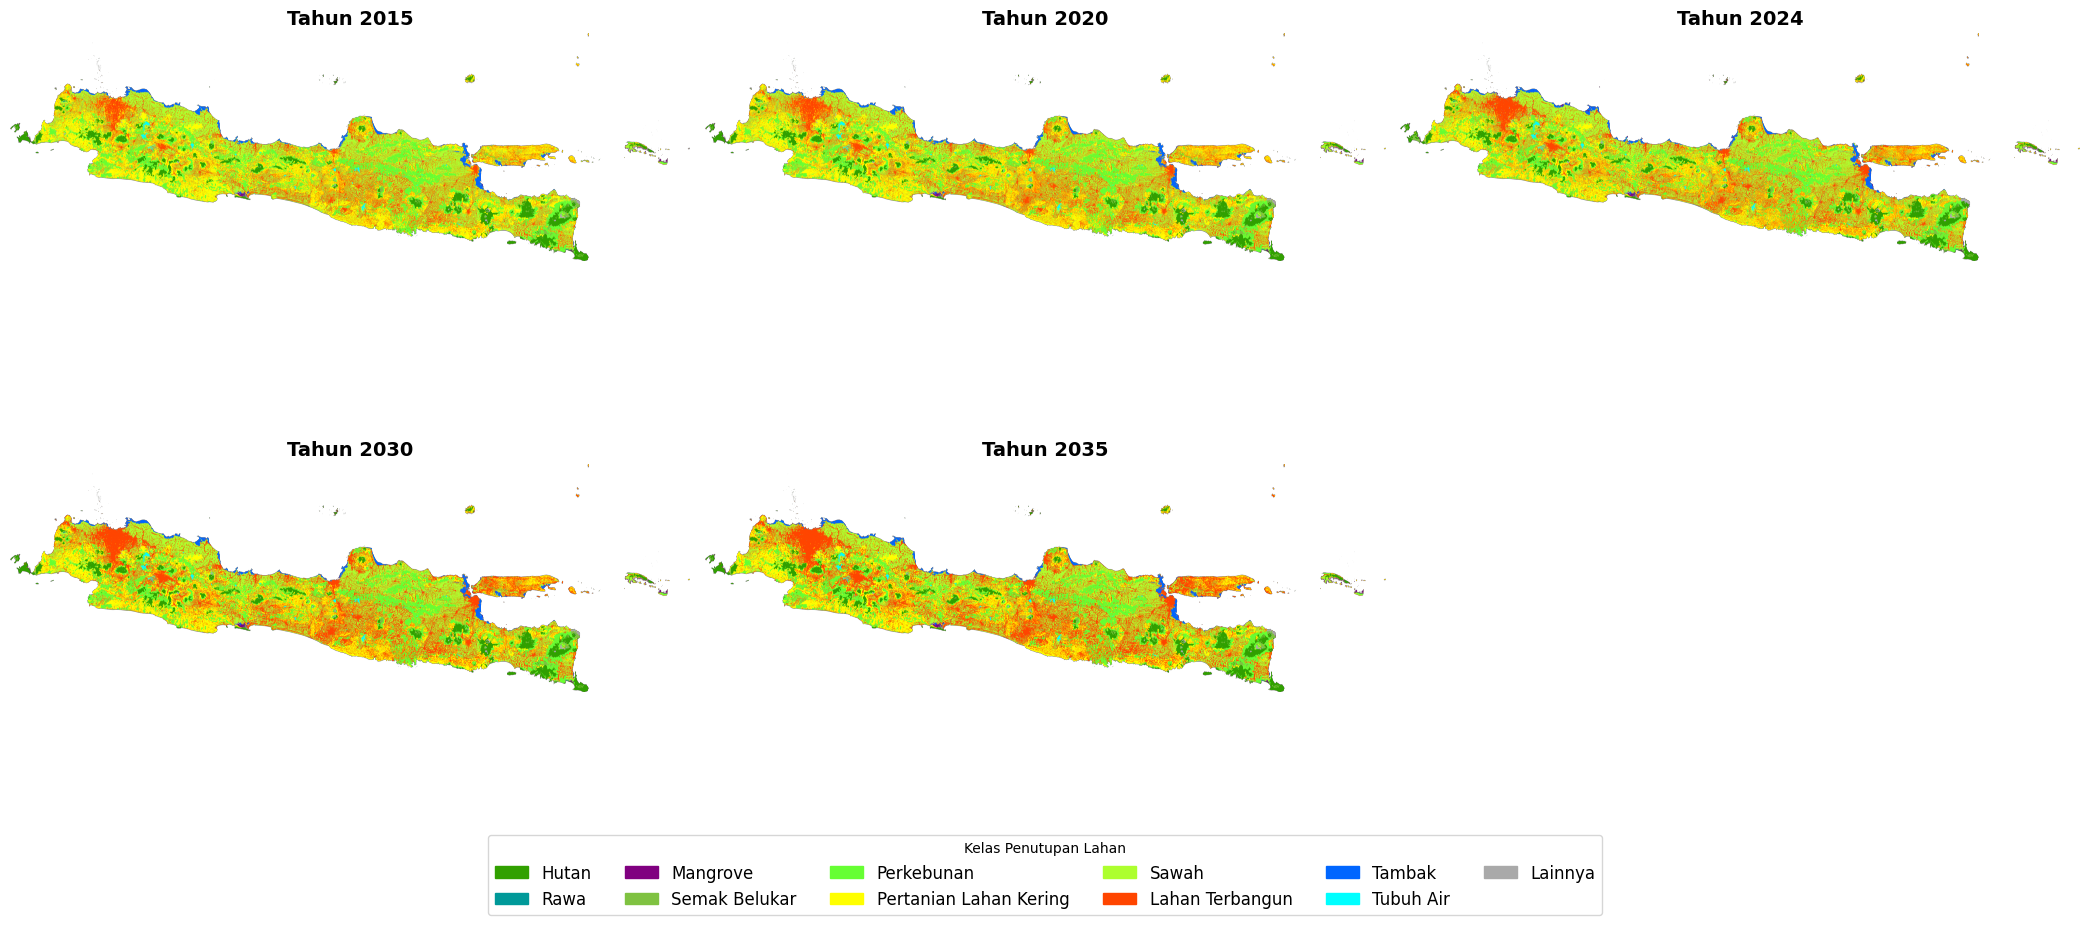


--- Visualisasi Matriks Transisi Histori & Proyeksi (Heatmap) ---


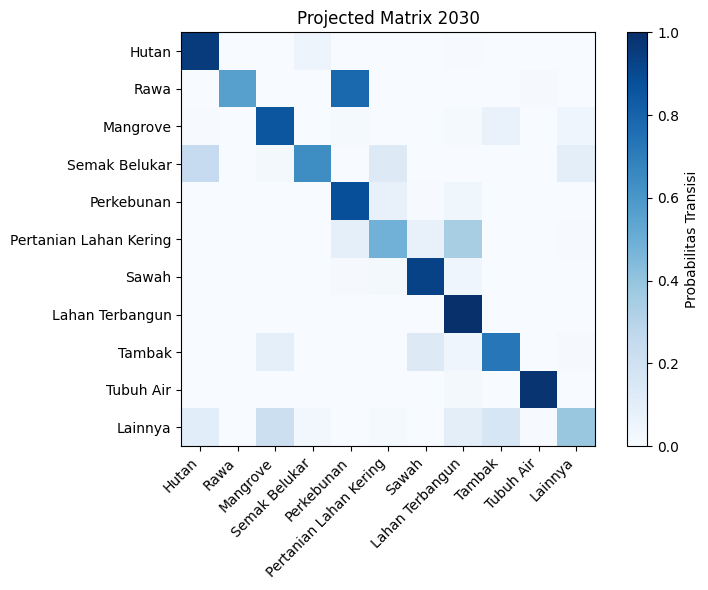

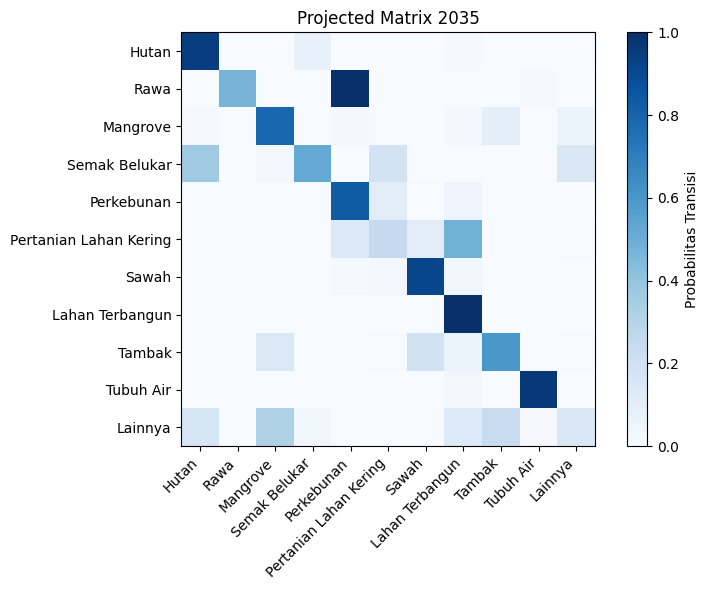

In [ ]:
# @title Visualisasi Hasil Simulasi
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import math
import logging

# =====================================================================
# SECTION 1: KONFIGURASI VISUALISASI
# =====================================================================
FINAL_TARGET_YEAR = TARGET_YEARS[-1]
PREDICTION_MODE = 'evolutionary'

CLASS_COLORS = {
    1: '#31a000',
    2: '#009999',
    3: '#800080',
    4: '#7FC241',
    5: '#66FF33',
    6: '#FFFF00',
    7: '#ADFF2F',
    8: '#FF4500',
    9: '#0066FF',
    10: '#00FFFF',
    11: '#A9A9A9',
}

logging.basicConfig(filename='viz_camar.log', level=logging.WARNING)

# =====================================================================
# SECTION 2: FUNGSI UTAMA
# =====================================================================

def calculate_land_use_areas(map_files_dict, class_labels):
    area_data = {}
    transform = None
    area_per_pixel_ha = None

    for year, (filename, data_source_dir) in map_files_dict.items():
        filepath = os.path.join(data_source_dir, filename)
        if not os.path.exists(filepath):
            print(f"Warning: File peta untuk tahun {year} ('{filename}') tidak ditemukan. Melewati perhitungan luas.")
            continue

        with rasterio.open(filepath) as src:
            data = src.read(1)
            nodata = src.nodata

            if transform is None:
                transform = src.transform
                pixel_size_x = abs(transform.a)
                pixel_size_y = abs(transform.e)
                if src.crs and src.crs.is_projected and src.crs.linear_units.lower() in ['metre', 'meter']:
                    area_per_pixel_ha = (pixel_size_x * pixel_size_y) / 10000
                else:
                    area_per_pixel_ha = pixel_size_x * pixel_size_y

        class_counts = {cls_code: 0 for cls_code in class_labels.keys()}
        unique, counts = np.unique(data[data != nodata], return_counts=True)
        for cls_code, count in zip(unique, counts):
            if cls_code in class_counts:
                class_counts[cls_code] = count * area_per_pixel_ha
        area_data[year] = class_counts

    if not area_data:
        return None
    df_area = pd.DataFrame(area_data).fillna(0)
    df_area.index = [class_labels.get(i, f'Kelas {i}') for i in df_area.index]
    return df_area.loc[sorted(df_area.index)].sort_index()

def visualize_map_sequence(map_files_dict, class_labels, class_colors_dict, save_path=None):
    print("\n--- Menghasilkan Visualisasi Urutan Peta ---")
    valid_maps = {
        year: (filename, data_source_dir)
        for year, (filename, data_source_dir) in map_files_dict.items()
        if os.path.exists(os.path.join(data_source_dir, filename))
    }
    if not valid_maps:
        print("Error: Tidak ada file peta yang valid untuk divisualisasikan.")
        return
    try:
        n_maps = len(valid_maps)
        n_cols = int(np.ceil(np.sqrt(n_maps)))
        n_rows = math.ceil(n_maps / n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7, n_rows * 5.5), squeeze=False)
        axes = axes.flatten()
        all_class_codes = sorted(class_labels.keys())
        all_colors = [class_colors_dict.get(k, '#FFFFFF') for k in all_class_codes]
        cmap = ListedColormap(all_colors)
        boundaries = [code - 0.5 for code in all_class_codes] + [all_class_codes[-1] + 0.5]
        norm = plt.Normalize(vmin=min(boundaries), vmax=max(boundaries))
        i = 0
        for year, (filename, data_source_dir) in valid_maps.items():
            ax = axes[i]
            filepath = os.path.join(data_source_dir, filename)
            with rasterio.open(filepath) as src:
                img = src.read(1)
                nodata = src.nodata
            img_masked = np.ma.masked_where(img == nodata, img)
            ax.imshow(img_masked, cmap=cmap, norm=norm)
            ax.set_title(f"Tahun {year}", weight='bold', fontsize=14)
            ax.axis('off')
            i += 1
        for j in range(i, len(axes)):
            axes[j].set_visible(False)
        legend_patches = [Patch(color=color, label=label) for code, label in class_labels.items() for color in [class_colors_dict.get(code)]]
        fig.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, 0.02),
                   ncol=min(6, len(class_labels)), title='Kelas Penutupan Lahan', frameon=True, fontsize=12)
        plt.tight_layout(rect=[0, 0.08, 1, 0.98])
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualisasi urutan peta disimpan sebagai: {save_path}")
        plt.show()
    except Exception as e:
        print(f"Error saat membuat visualisasi urutan peta: {e}")
        logging.error(f"Gagal membuat visualisasi urutan peta: {e}", exc_info=True)

def plot_area_change(df_area_change, class_colors):
    """Stacked Bar Chart perubahan luas tiap kelas dengan warna sesuai peta."""
    plt.figure(figsize=(12, 6))

    # Ambil kode kelas dari index nama
    kelas_index = df_area_change.index.tolist()
    # Buat mapping terbalik dari label ke kode
    label_to_code = {v: k for k, v in LULC_CLASS.items()}
    warna = [class_colors.get(label_to_code.get(kelas, -1), "#999999") for kelas in kelas_index]

    df_area_change.T.plot(kind='bar', stacked=True, color=warna)

    plt.title("Tren Perubahan Luas Tutupan Lahan per Tahun")
    plt.xlabel("Tahun")
    plt.ylabel("Luas (ha)")
    plt.legend(title='Kelas', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_transition_heatmap(matrix_csv_path, title="Matriks Transisi", class_labels=None):
    """Visualisasi matriks transisi sebagai heatmap."""
    df = pd.read_csv(matrix_csv_path, index_col=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(df, cmap="Blues", vmin=0, vmax=1)
    plt.colorbar(label="Probabilitas Transisi")
    plt.xticks(ticks=np.arange(len(df.columns)), labels=df.columns, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(df.index)), labels=df.index)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# =====================================================================
# SECTION 3: MAIN EXECUTION BLOCK
# =====================================================================
if __name__ == '__main__':

    all_map_files = {year: (map_file, DATA_DIR_INPUT) for year, map_file in zip(HISTORICAL_TIME_STEPS, HISTORICAL_MAPS)}
    for year in TARGET_YEARS:
        pred_file = f"predicted_map_{PREDICTION_MODE}_{year}.tif"
        all_map_files[year] = (pred_file, DATA_DIR_OUTPUT)
    all_map_files = dict(sorted(all_map_files.items()))

    # --- Hitung dan Tampilkan Tabel Luas Lahan ---
    df_area_change = calculate_land_use_areas(all_map_files, LULC_CLASS)
    if df_area_change is not None and not df_area_change.empty:
        print("\n" + "="*60)
        print("Tabel Detail Perubahan Luas (Hektar)")
        print("="*60)
        df_area_formatted = df_area_change.map(lambda x: f"{x:,.0f}")
        print(df_area_formatted)
        # Export ke Excel
        path_xlsx = os.path.join(DATA_DIR_OUTPUT, "tabel_perubahan_luas.xlsx")
        df_area_change.to_excel(path_xlsx)
        print(f"Data perubahan luas diekspor ke: {path_xlsx}")
        # Warning jika ada kelas yang selalu 0
        for kelas, total in df_area_change.sum(axis=1).items():
            if total == 0:
                print(f"Warning: Kelas '{kelas}' tidak muncul sama sekali di semua tahun.")
        # Visualisasi stacked bar perubahan area
        plot_area_change(df_area_change, CLASS_COLORS)
    else:
        print("Tidak dapat menghitung atau menampilkan tabel perubahan luas.")

    # --- Tampilkan Visualisasi Peta ---
    visualize_map_sequence(
        map_files_dict=all_map_files,
        class_labels=LULC_CLASS,
        class_colors_dict=CLASS_COLORS,
        save_path=os.path.join(DATA_DIR_OUTPUT, "visualisasi_sekuens_peta.png")
    )

    # --- (Opsional) Visualisasi Matriks Transisi Histori dan Proyeksi ---
    print("\n--- Visualisasi Matriks Transisi Histori & Proyeksi (Heatmap) ---")
    matrix_files = []
    for fname in os.listdir(DATA_DIR_OUTPUT):
        if fname.startswith("transition_matrix_") and fname.endswith(".csv"):
            matrix_files.append(fname)
    for fname in os.listdir(DATA_DIR_OUTPUT):
        if fname.startswith("projected_matrix_") and fname.endswith(".csv"):
            matrix_files.append(fname)
    matrix_files = sorted(matrix_files)
    for fname in matrix_files:
        matrix_path = os.path.join(DATA_DIR_OUTPUT, fname)
        title = fname.replace(".csv", "").replace("_", " ").title()
        plot_transition_heatmap(matrix_path, title=title)
